In [1]:
from netCDF4 import Dataset, num2date
import numpy as np
import pandas as pd
import xarray as xr
import os
import time
import matplotlib.pyplot as plt
import matplotlib
import gc
from matplotlib import transforms
import matplotlib.colors as clrs
import glob

In [2]:
for i in np.arange(0,12):
    filename = "/gpfs/fs7/dfo/hpcmc/comda/stod000/DATA/POC/poc_monthly_"+str(i+1)+"_CREG025.nc"
    data = Dataset(filename, "r", format="NETCDF4")
    X = data.variables['poc'][:]
    X = X/12
    if i==0:
        [ny,nx]=np.shape(X)
        obsPOC=np.zeros((12,ny,nx))
    obsPOC[i,:,:]=X

print(np.shape(obsPOC), np.nanmin(obsPOC), np.nanmean(obsPOC), np.nanmax(obsPOC))


/tmp/ipykernel_152683/1201940627.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = data.variables['poc'][:]


(12, 735, 528) 0.0 6.68426298497456 83.33333587646484


In [3]:
data_file = Dataset("/gpfs/fs7/dfo/hpcmc/comda/stod000/CREG25/regions_mask_6.nc", "r", format="NETCDF4")
regindx = (data_file['regions_mask'][:])
print(regindx.shape)

data_file = Dataset("/home/fid000/WORK7/ANALYSIS/DATA/CREG025_mesh_mask.nc", "r", format="NETCDF4")
tmask = (data_file['tmask'][0,:,:,:])
print(tmask.shape)

print(np.nanmin(regindx),np.nanmean(regindx),np.nanmax(regindx))
print(np.min(tmask),np.mean(tmask),np.max(tmask))

tmask0=tmask[0,:,:].squeeze()

nxy=np.size(regindx)
I = np.reshape(regindx, (nxy,))
nreg=int(max(I))
mask = regindx
mask = mask.flatten()

/tmp/ipykernel_152683/2096643997.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  regindx = (data_file['regions_mask'][:])
/tmp/ipykernel_152683/2096643997.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tmask = (data_file['tmask'][0,:,:,:])


(735, 528)
(75, 735, 528)
0.0 2.0095472683383417 9.0
0 0.3011297327011613 1


/tmp/ipykernel_152683/2128647003.py:36: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  modPOC = data.variables['tPOC'][:]
/home/fid000/WORK7/software/anaconda3/envs/pypkg/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/fid000/WORK7/software/anaconda3/envs/pypkg/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


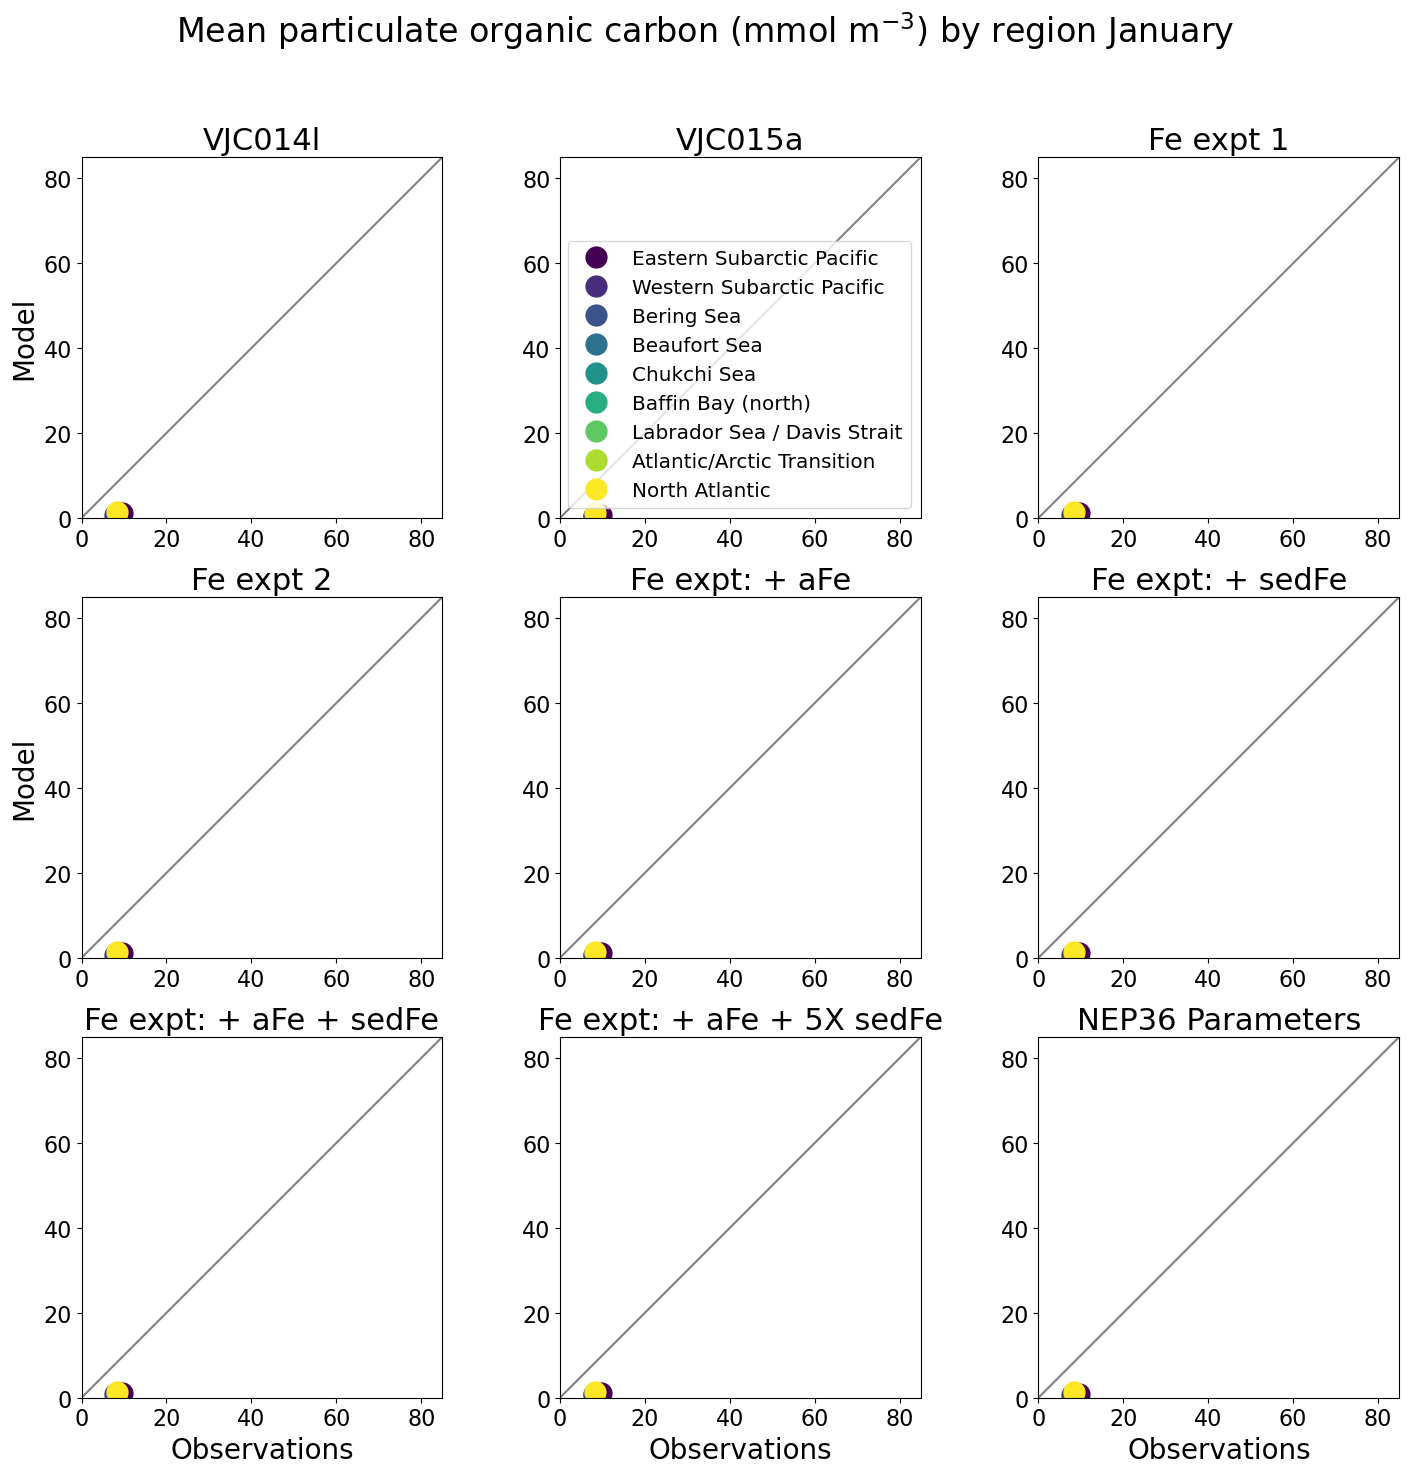

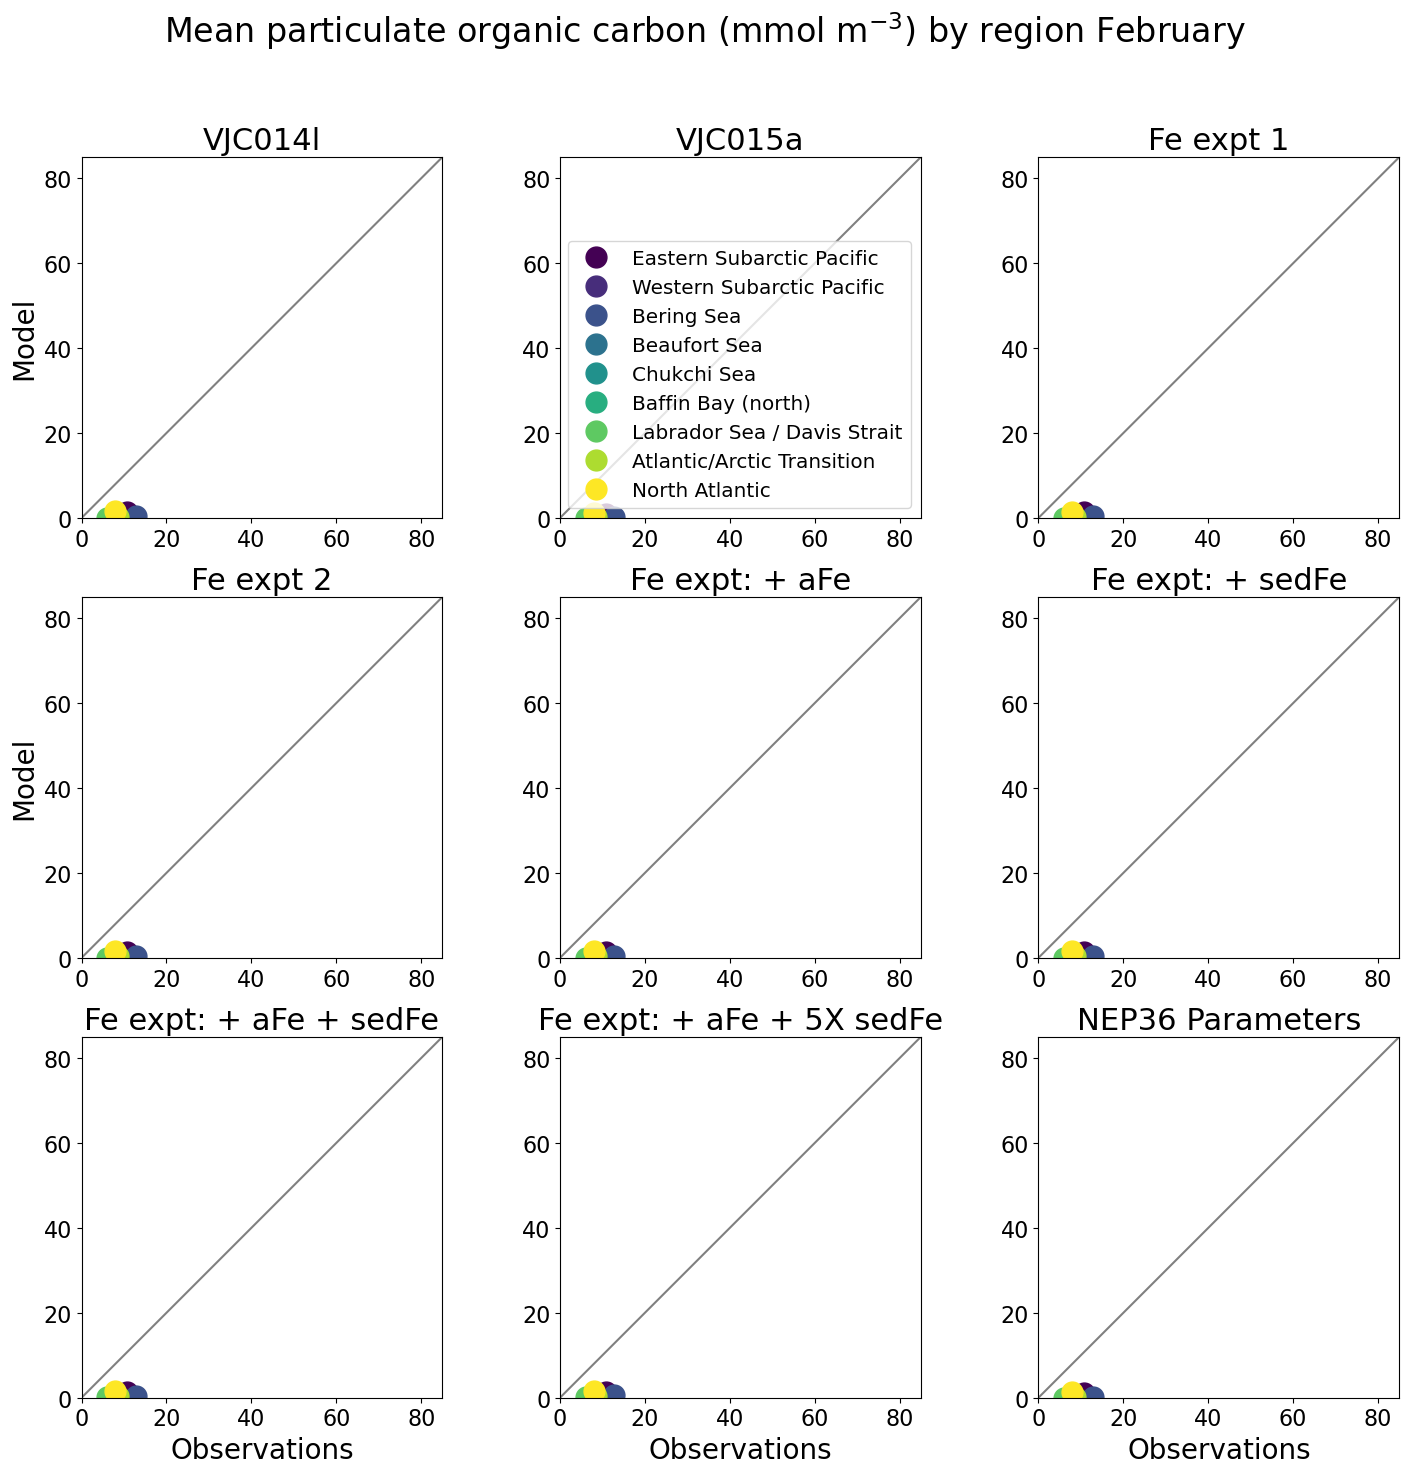

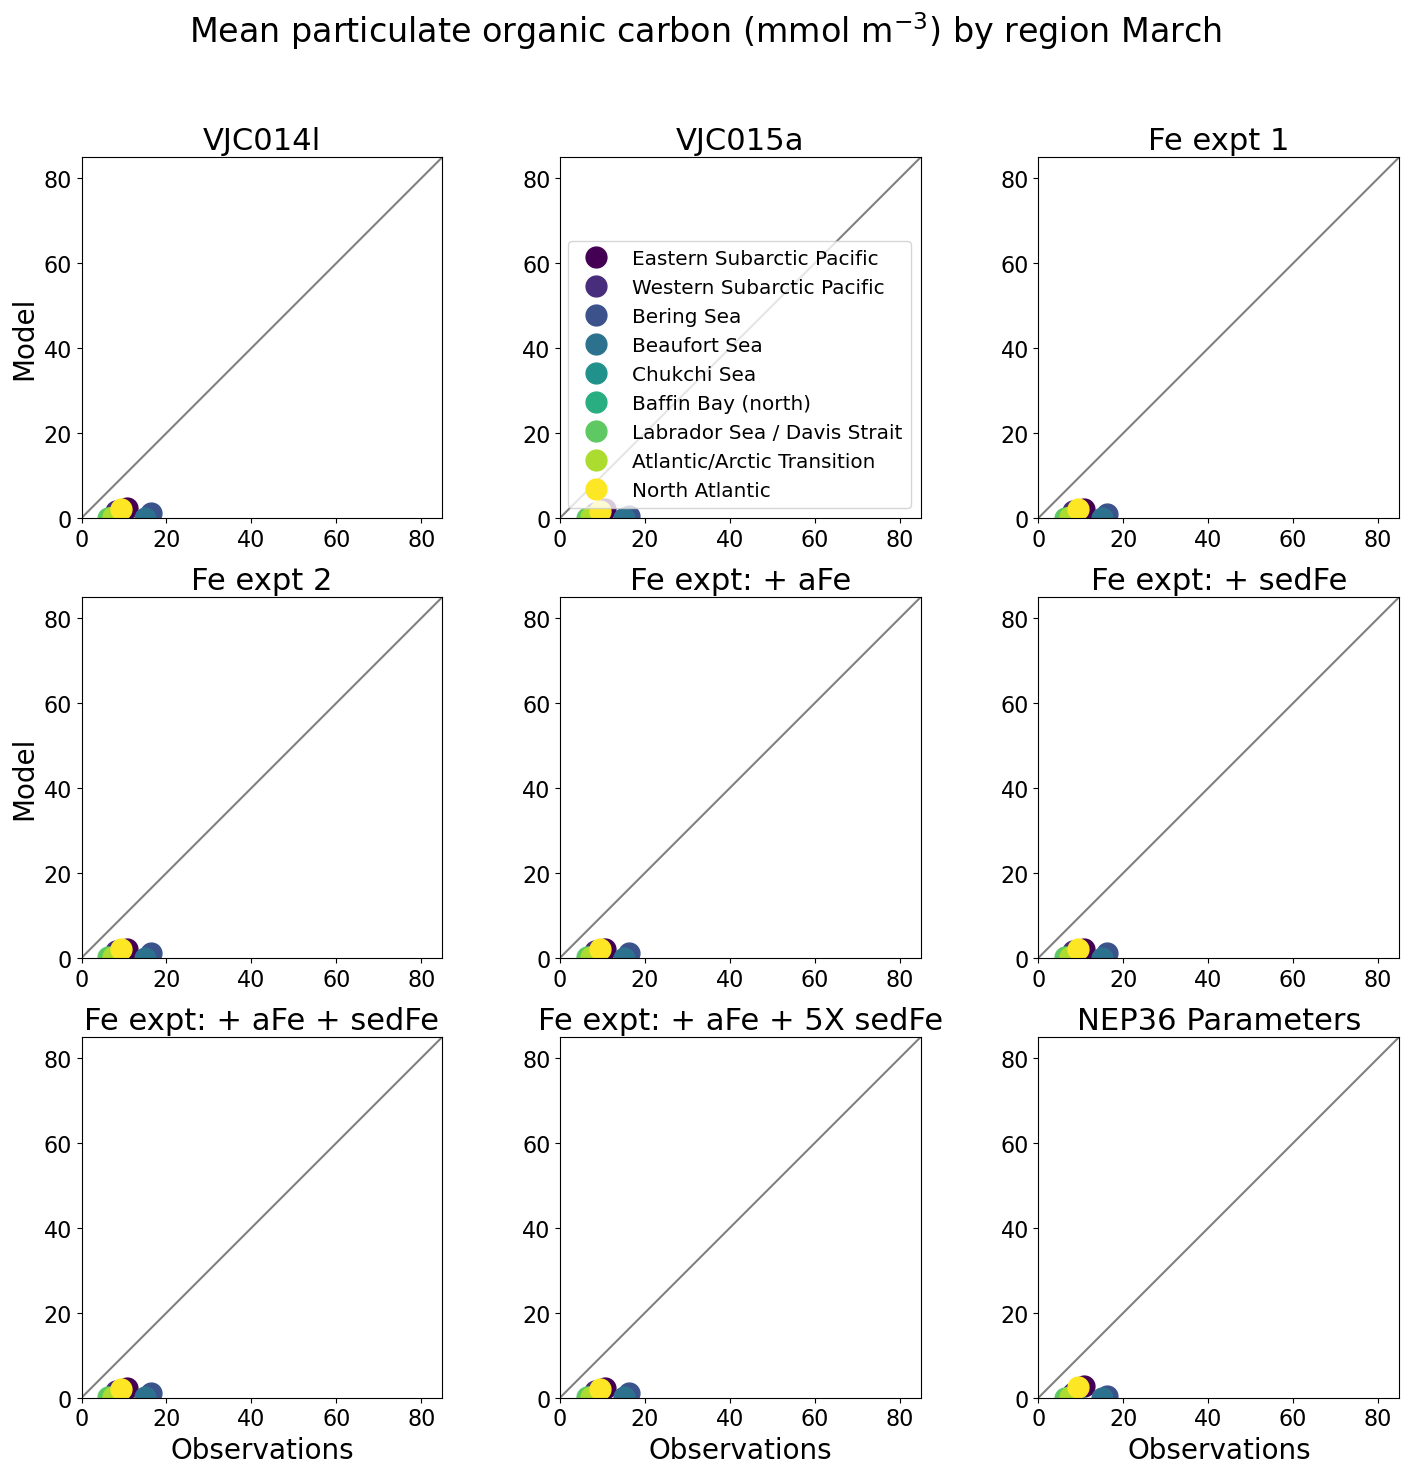

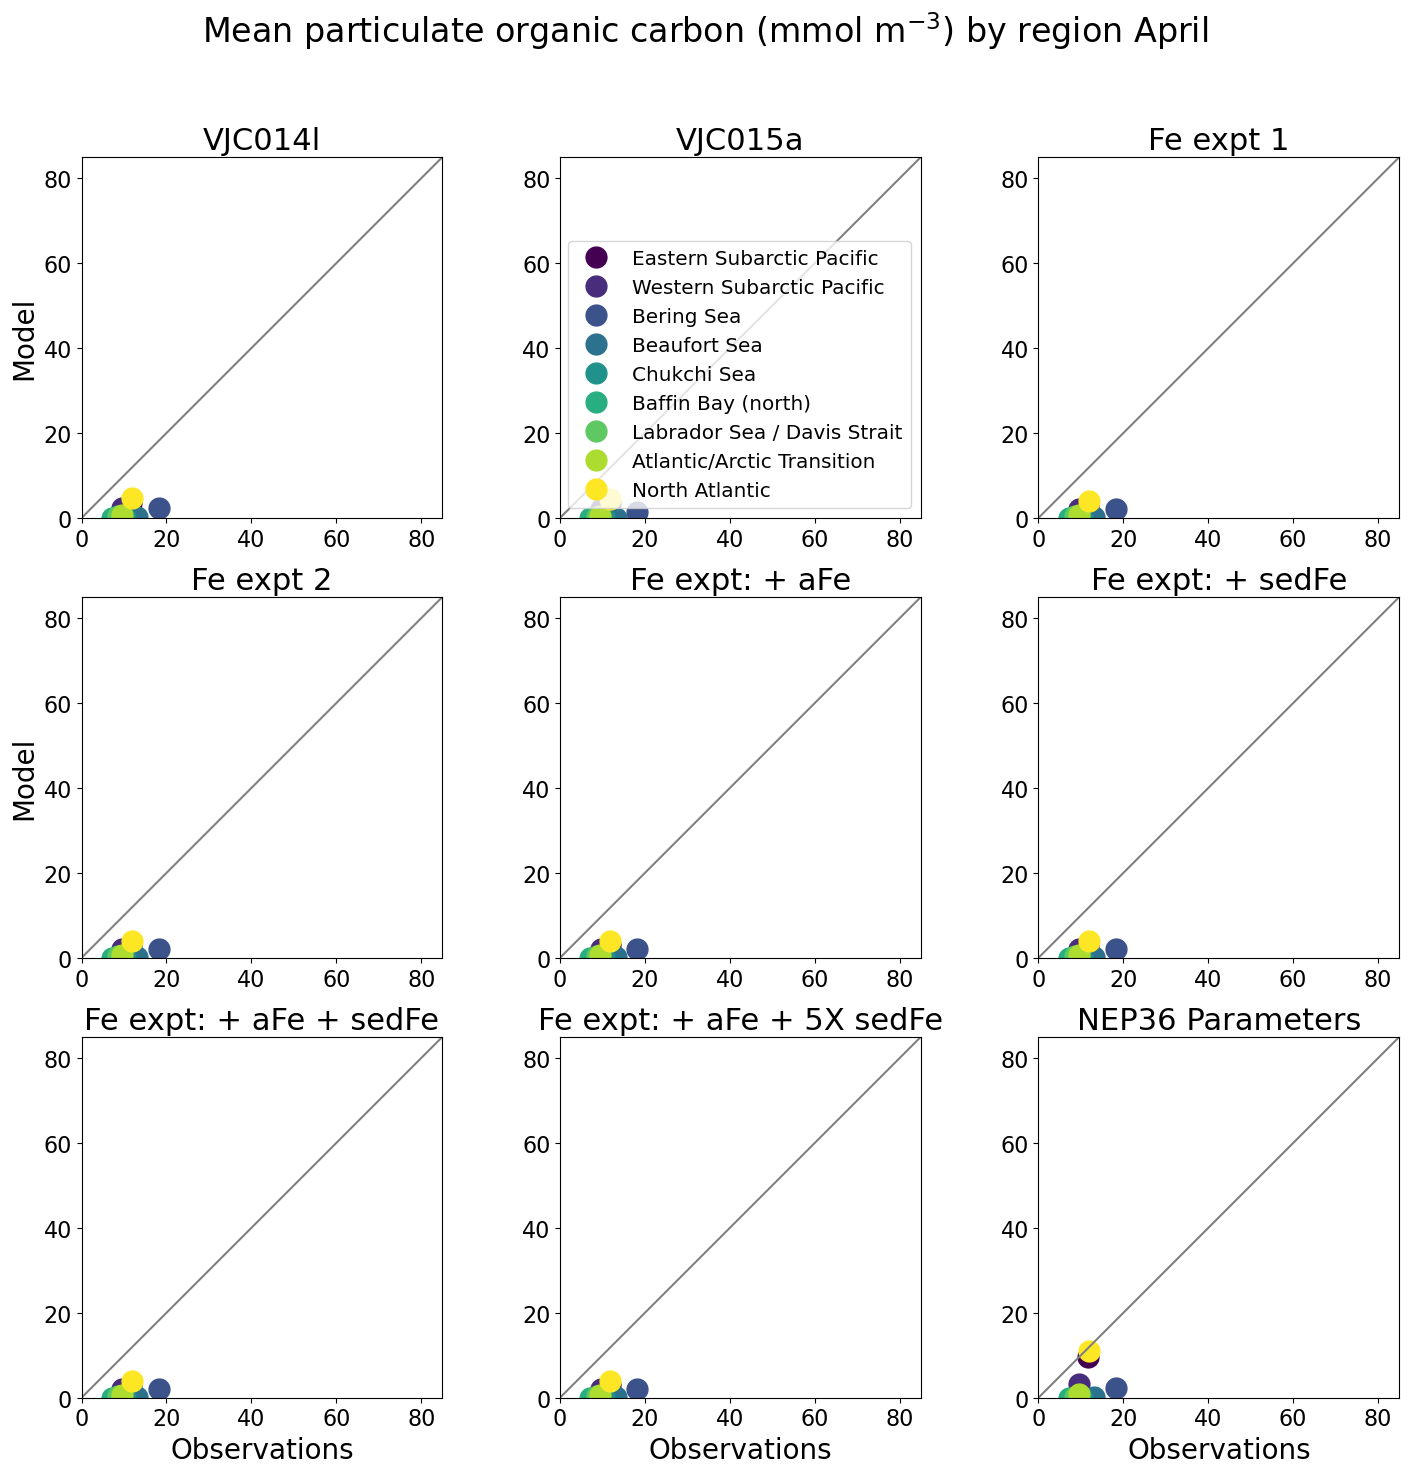

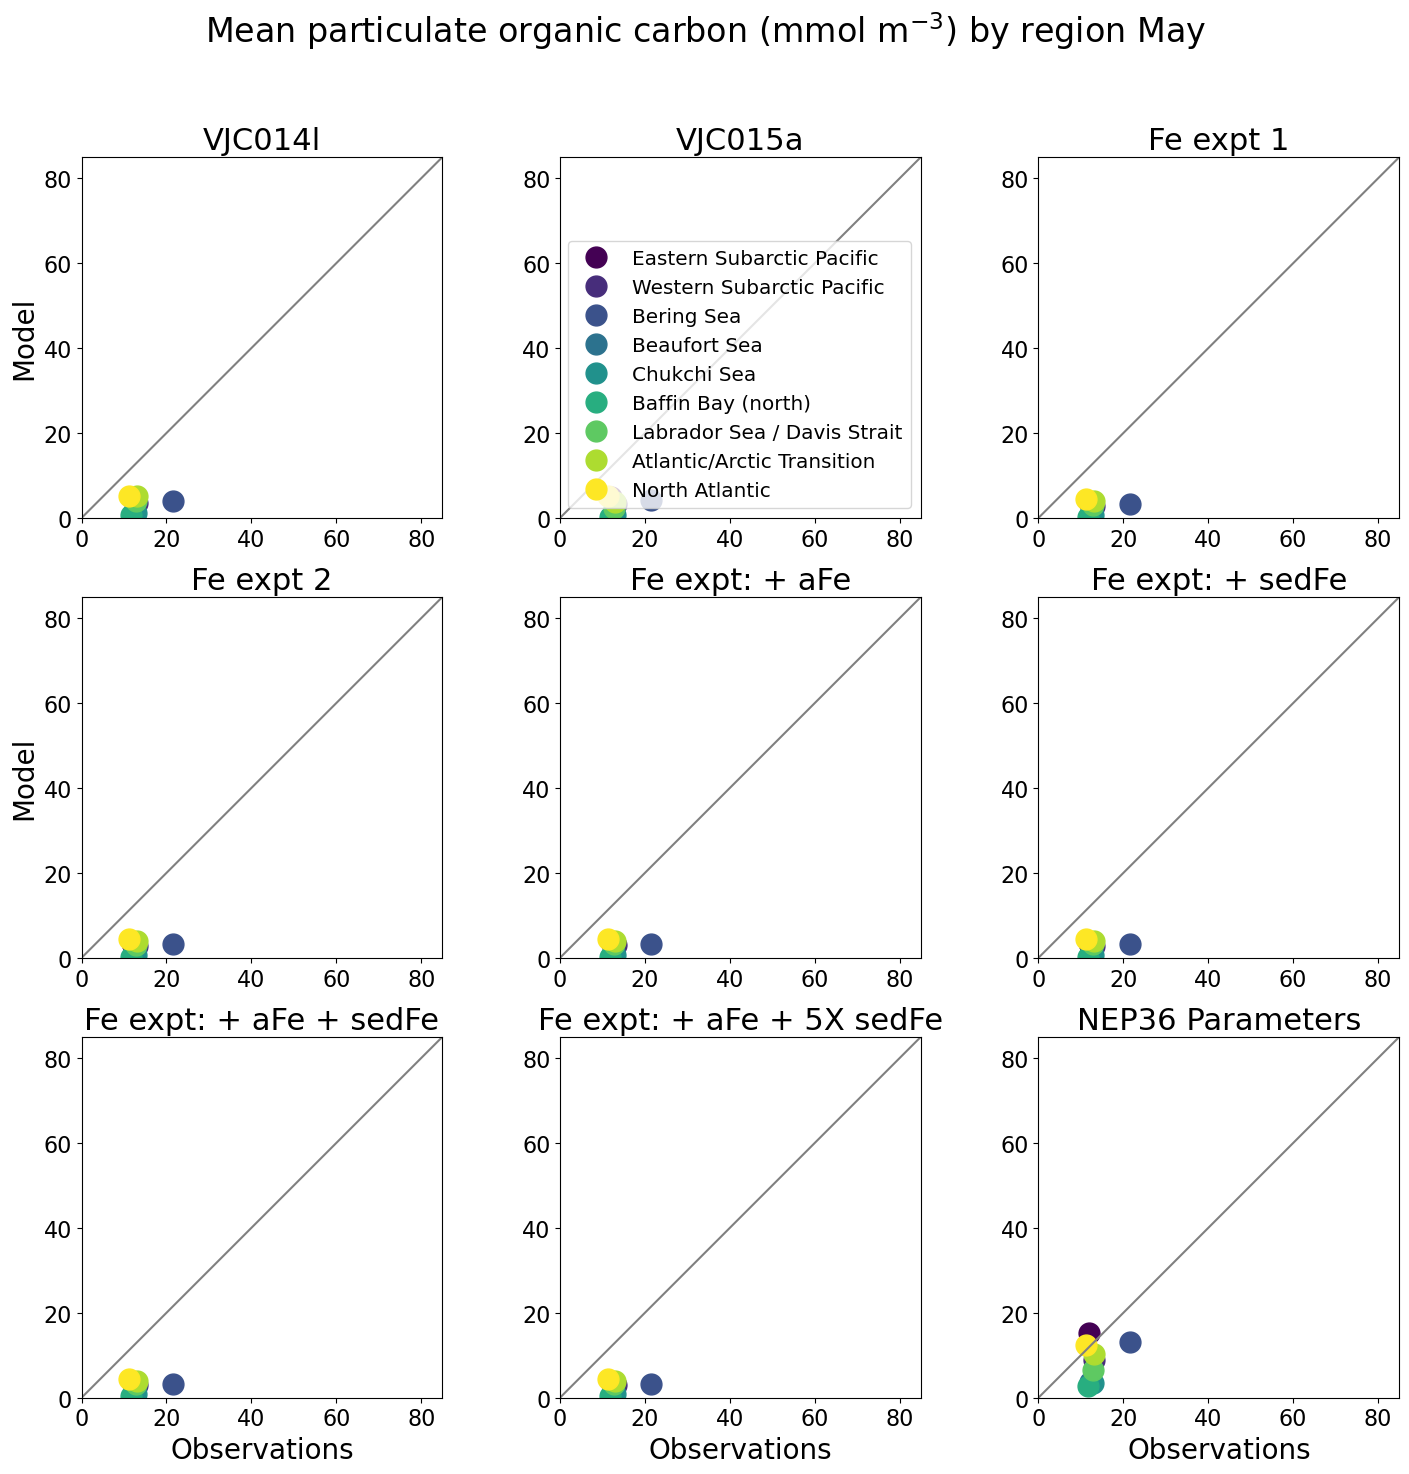

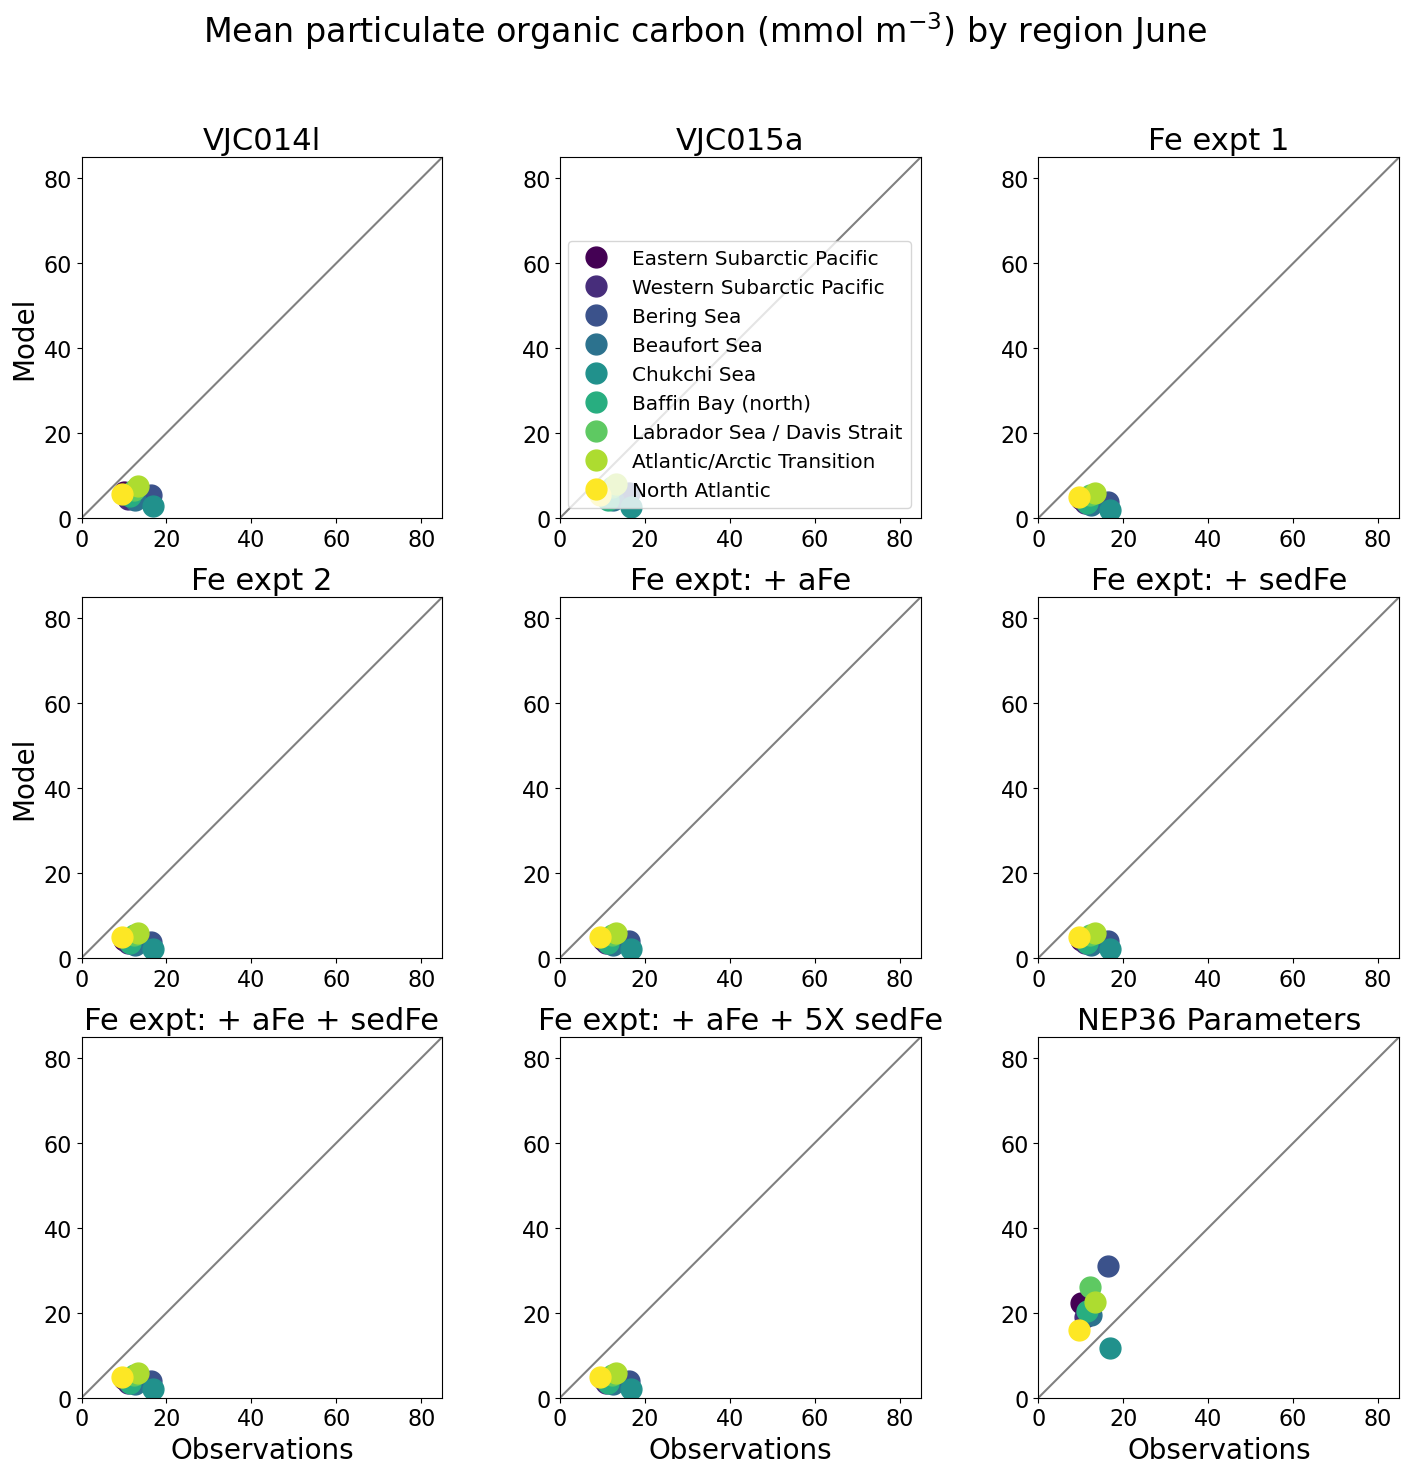

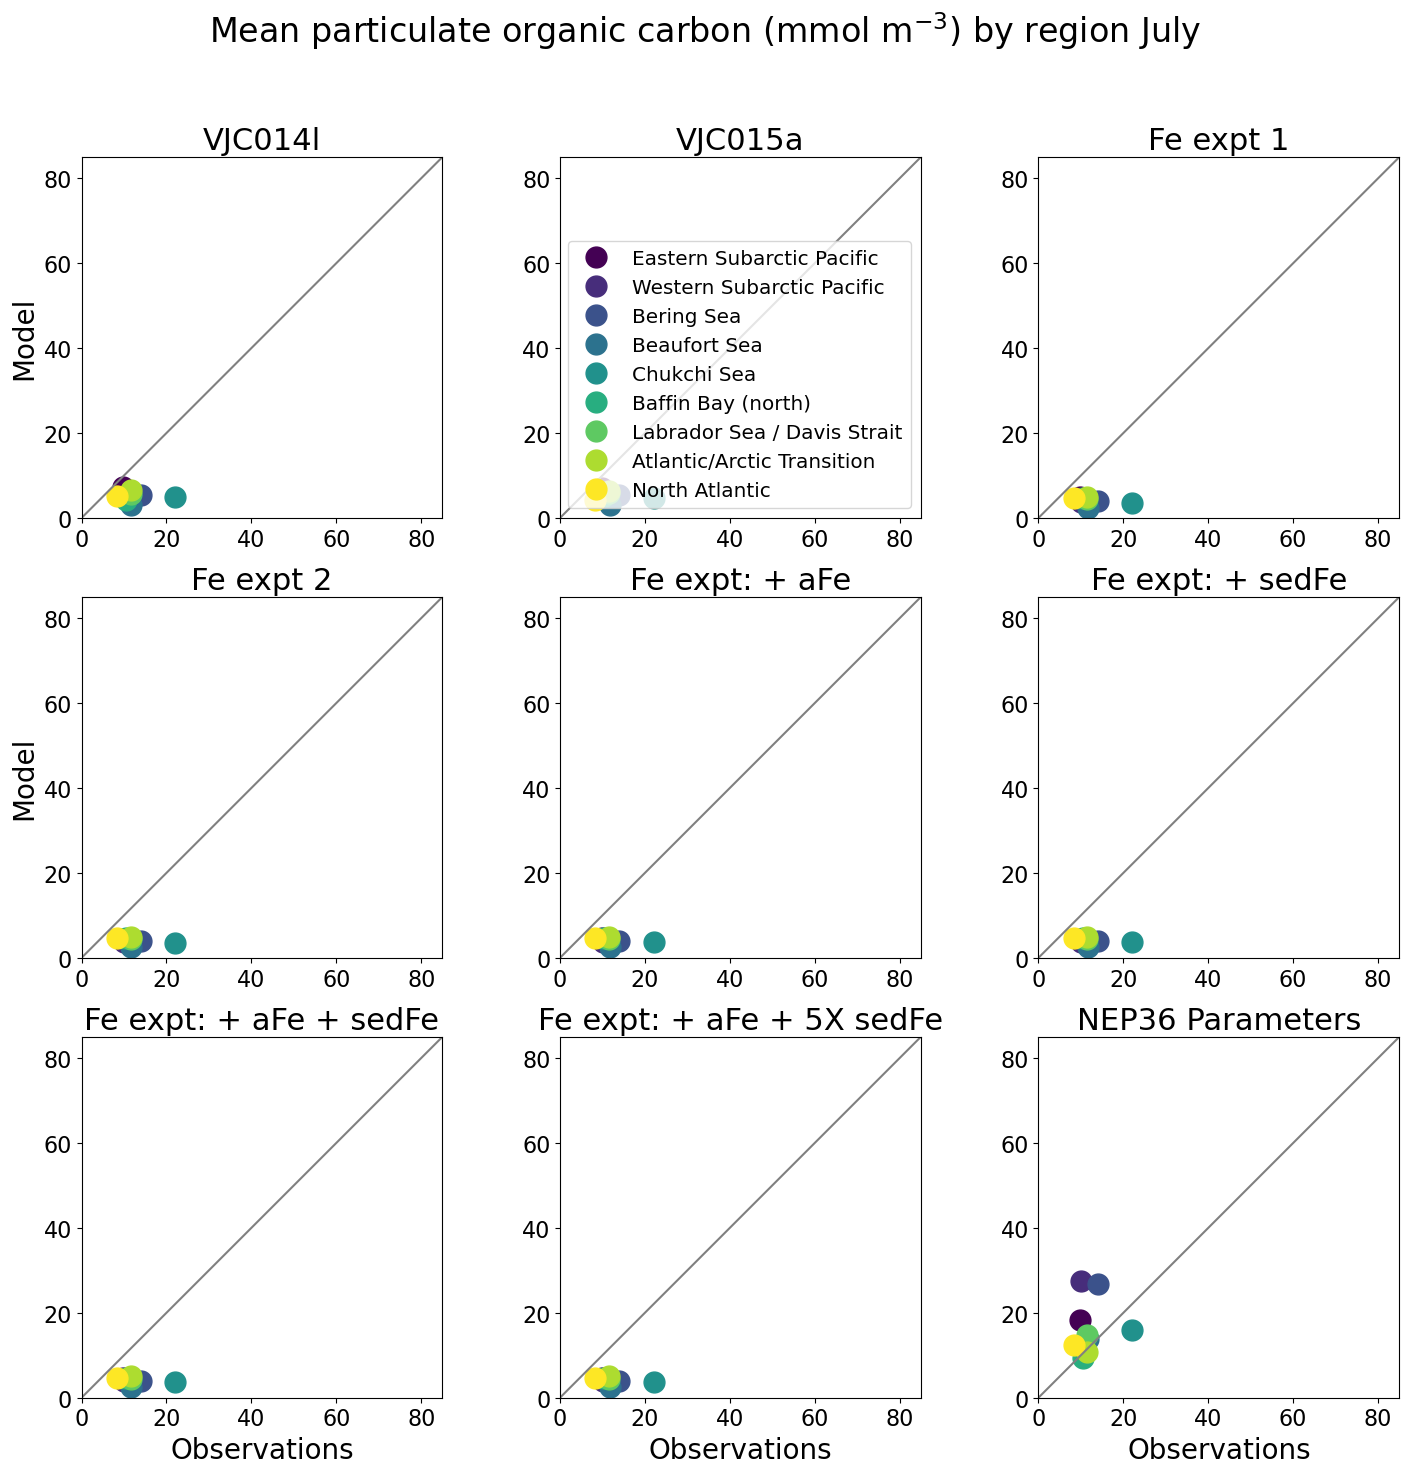

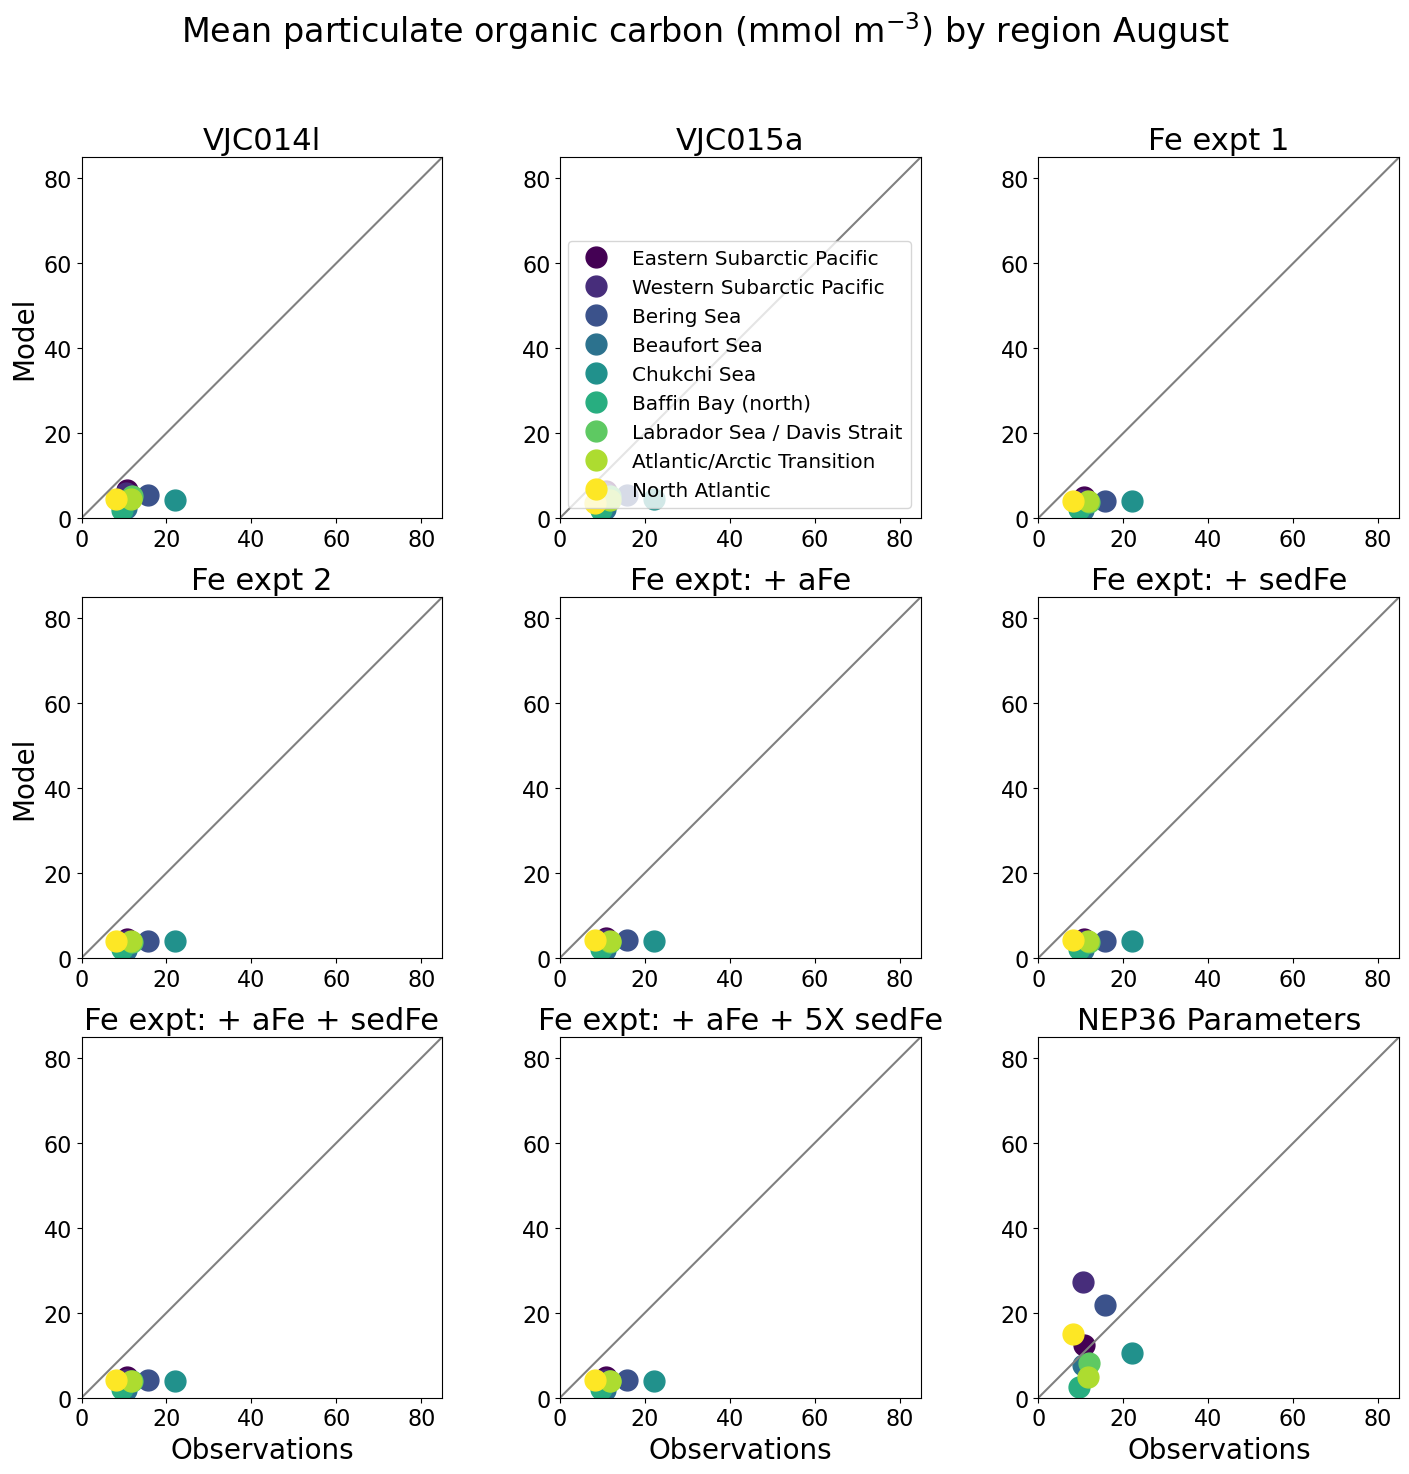

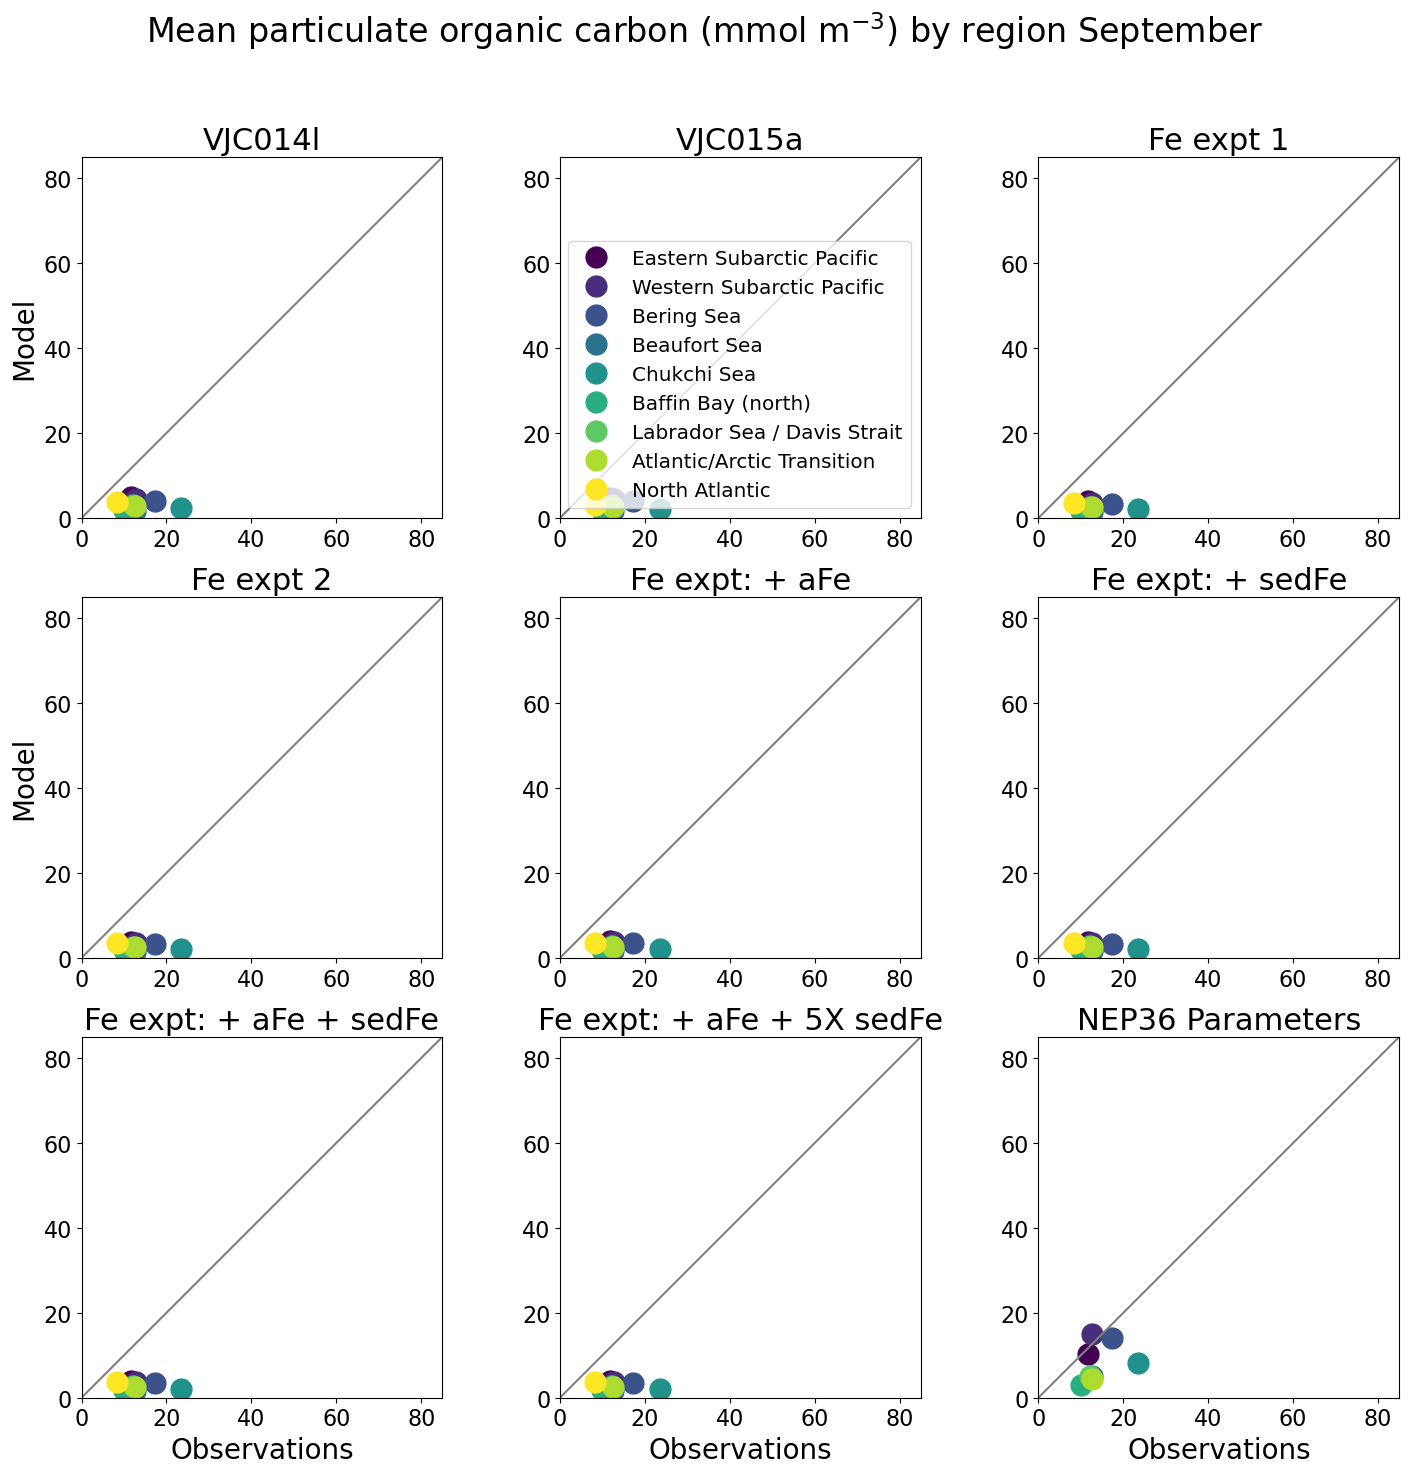

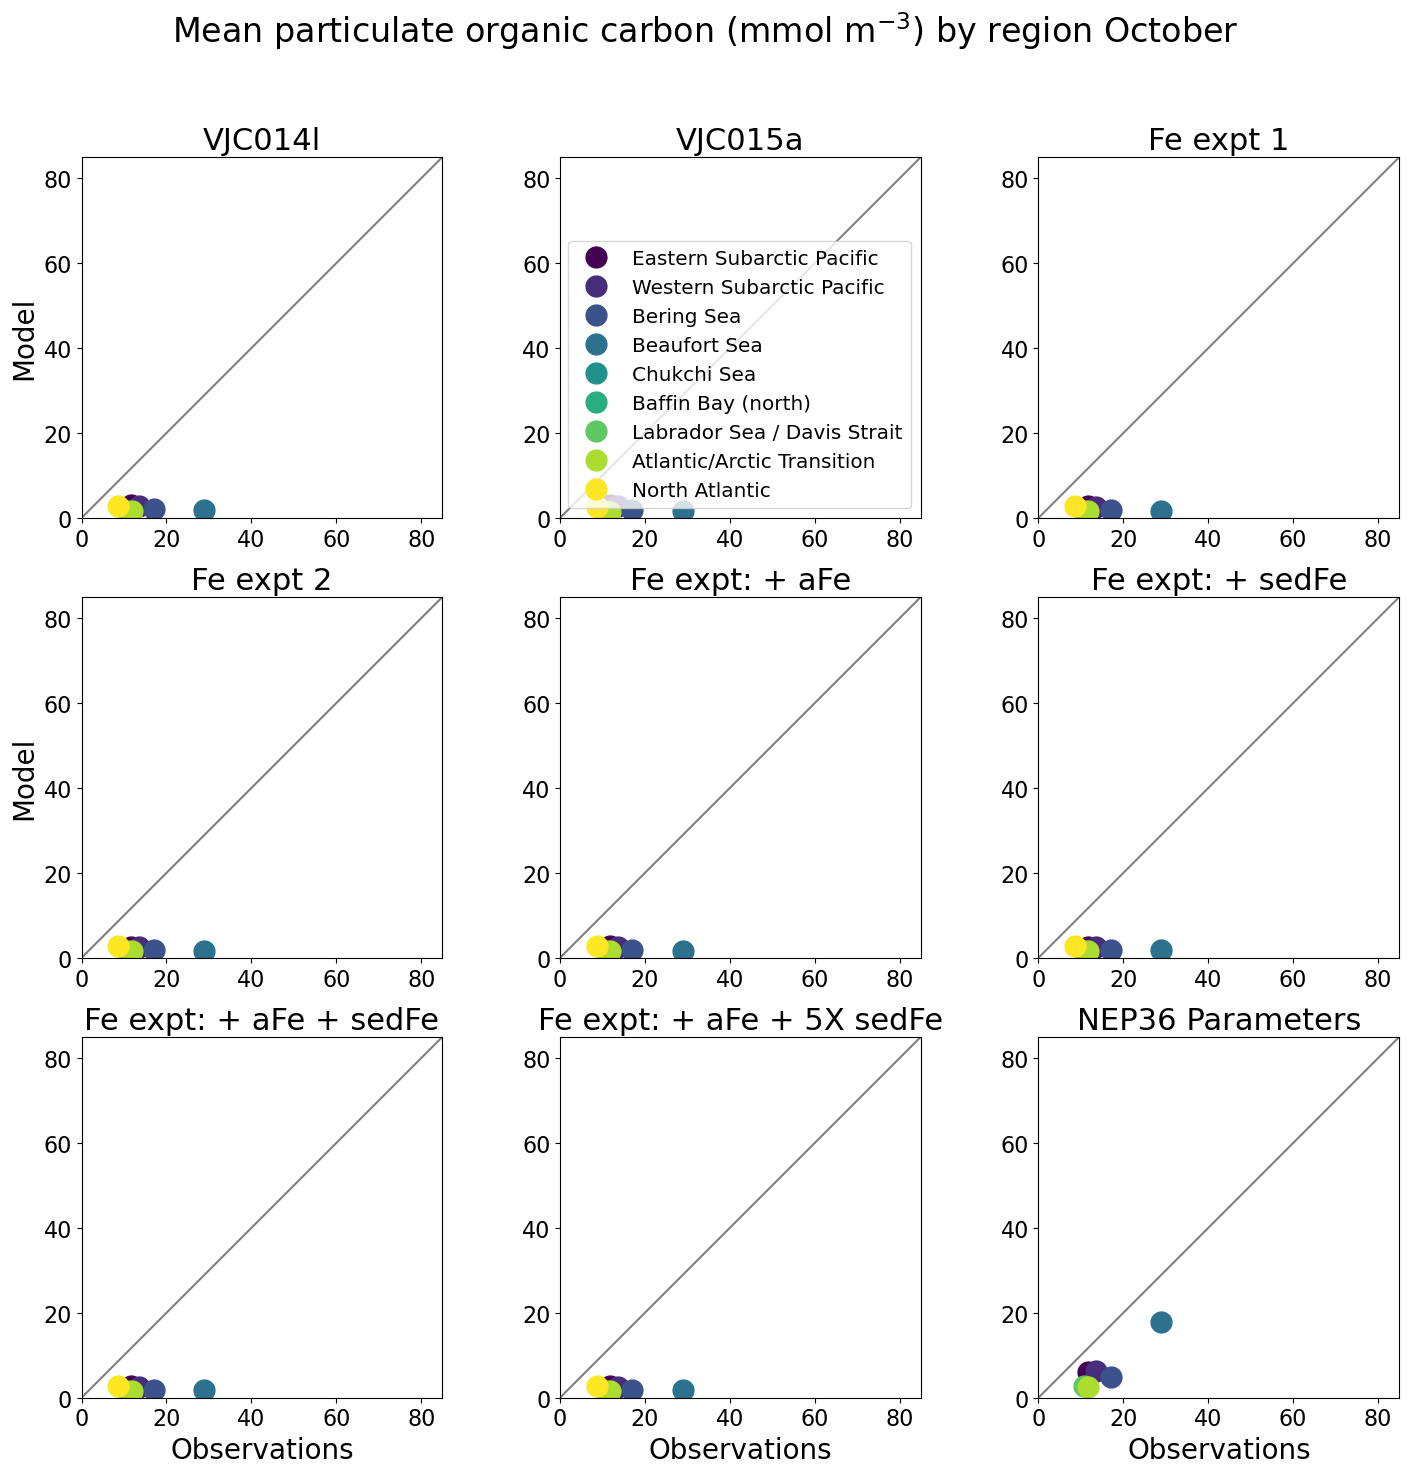

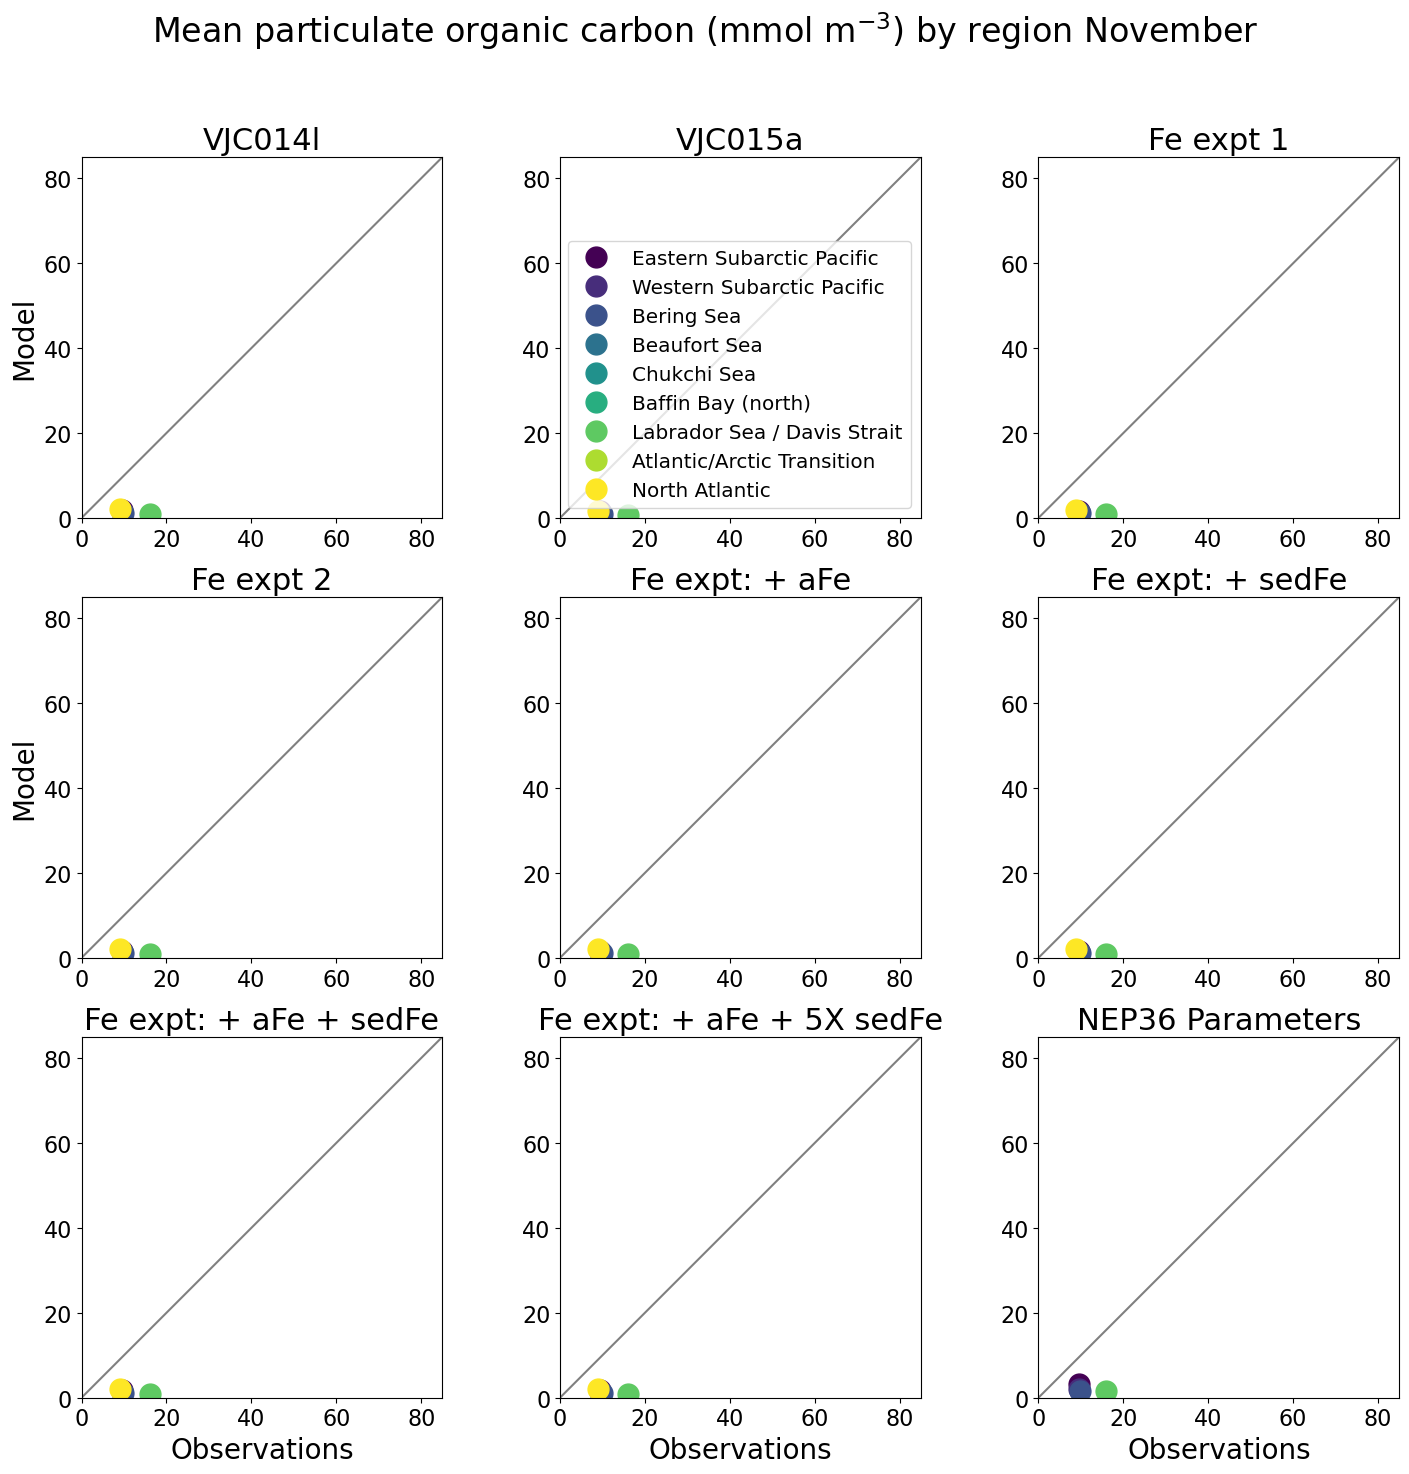

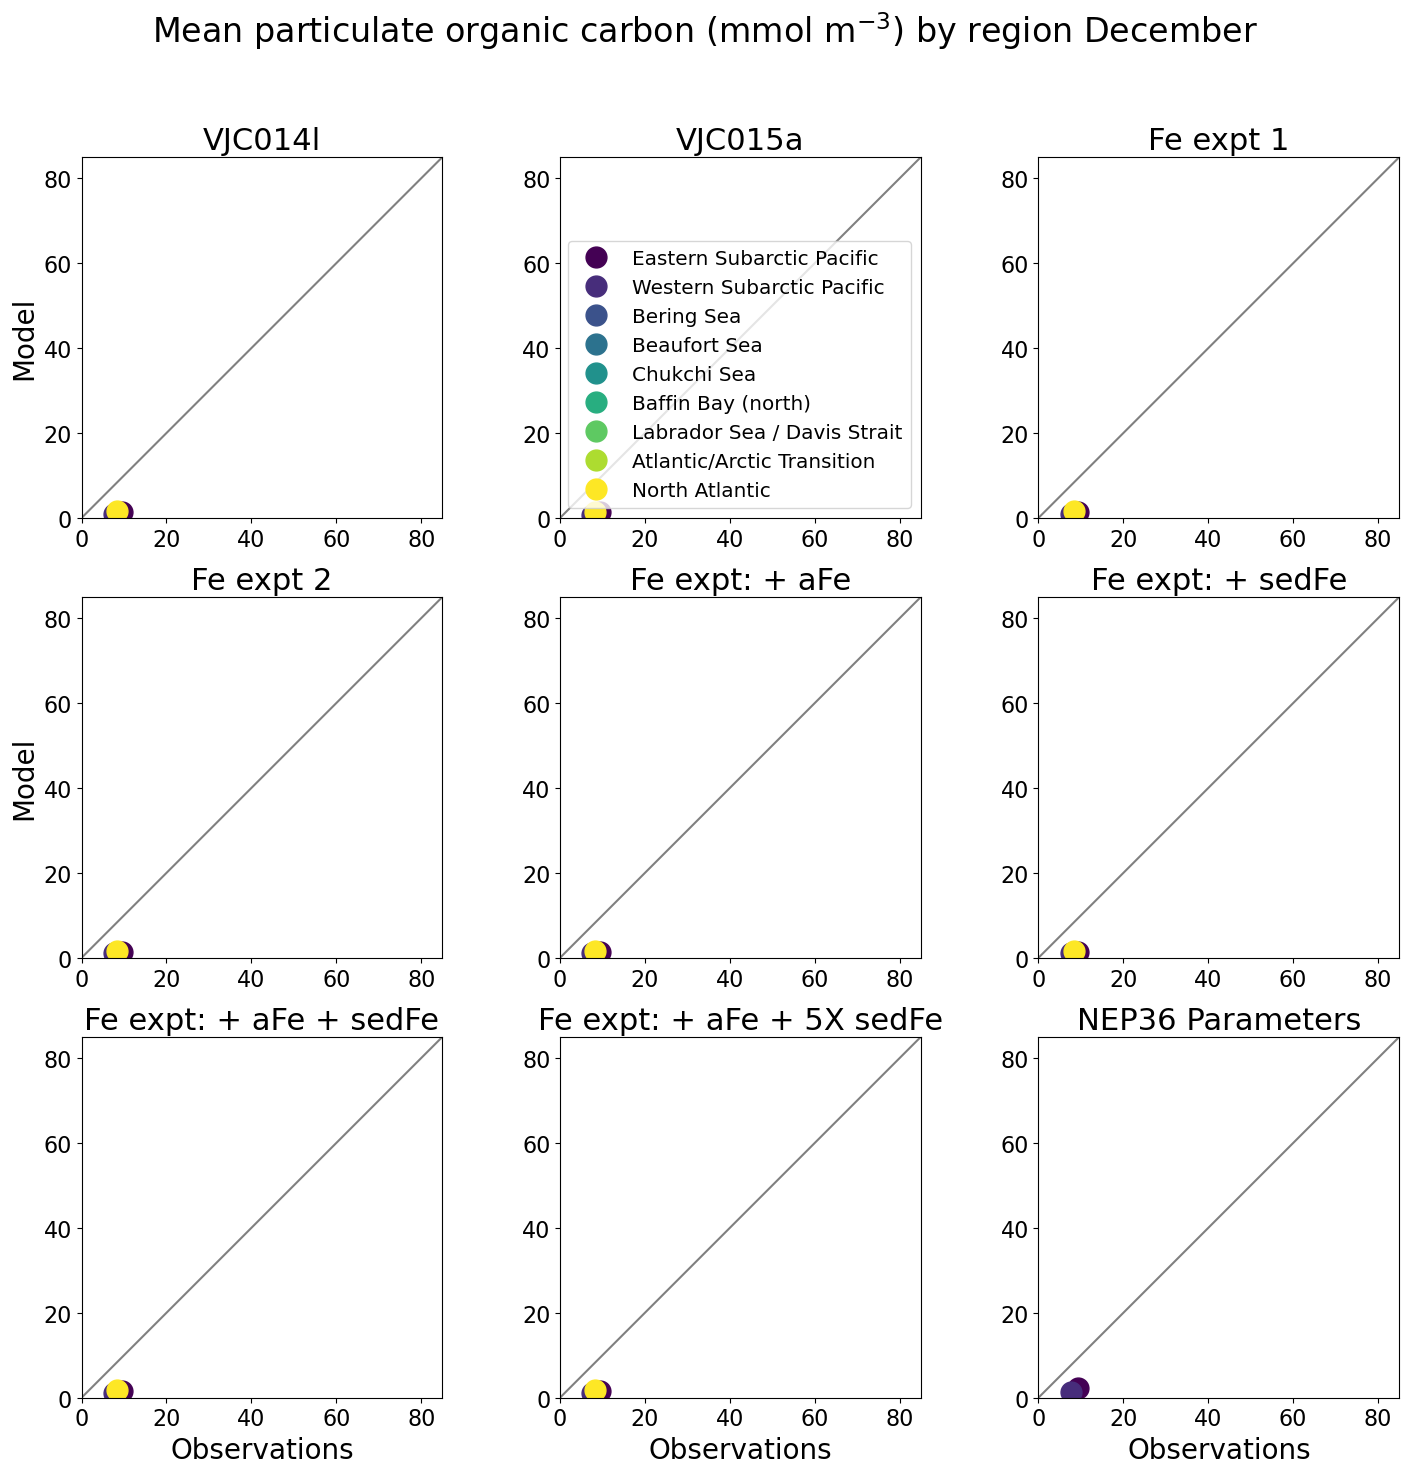

In [5]:
# Presentation quality plot for BioMod Workshop

regions = ['Eastern Subarctic Pacific', 'Western Subarctic Pacific', 'Bering Sea', 'Beaufort Sea', 'Chukchi Sea', 'Baffin Bay (north)', 'Labrador Sea / Davis Strait', 'Atlantic/Arctic Transition', 'North Atlantic']
import itertools
iz = np.arange(10)

months=['January','February','March','April','May','June','July','August','September','October','November','December']
regions = ['Eastern Subarctic Pacific', 'Western Subarctic Pacific', 'Bering Sea', 'Beaufort Sea', 'Chukchi Sea', 'Baffin Bay (north)', 'Labrador Sea / Davis Strait', 'Atlantic/Arctic Transition', 'North Atlantic']
variants = ['-VJC014l','-VJC015a','-VJC015oi','-VJC015ol','-VJC015on','-VJC015or','-VJC015os','-VJC015ot','-VJCnep01']
variantdict = ['VJC014l','VJC015a','Fe expt 1','Fe expt 2','Fe expt: + aFe','Fe expt: + sedFe','Fe expt: + aFe + sedFe',
               'Fe expt: + aFe + 5X sedFe','NEP36 Parameters']

for im, mmon in enumerate(months):
    
    fig, axes = plt.subplots(num=1, clear=True, nrows=3, ncols=3, figsize=(15, 15))
    fig.suptitle('Mean particulate organic carbon (mmol m$^{-3}$) by region '+mmon, fontsize=24) 
    #fig.suptitle('Particulate organic carbon concentration (mmol m$^{-3}$) by region '+mmon, fontsize=24) 

    for a, asuff in enumerate(variants):
        cx=plt.subplot(3,3, a+1)
        runid = str('CREG025_LIM3_CANOE'+asuff)
        #print(runid)
        data_all=np.zeros((12,ny,nx))
        flist = glob.glob("/home/fid000/WORK7/ANALYSIS/model_evaluation/MonthlyMeans/POC/"+runid+"_monthly_poc.nc")
        flist.sort()
        #print(flist)
        ifile = 0
        colors =itertools.cycle(plt.get_cmap('viridis')(np.linspace(0,1, 9))) # potential pallettes: hsv, jet, gnuplot

        for i, c in enumerate(regions): 
            
            if i >= 0:
                
                filein = flist[ifile]
                data = Dataset(filein, "r", format="NETCDF4")
                modPOC = data.variables['tPOC'][:]

                tmaskz=tmask[iz,:,:].flatten()
                ZZ=(np.zeros((10,ny,nx))+regindx).flatten()    # broadcast regions map into a 3D array with same data for each depth
                XOBS=obsPOC[im,:,:].squeeze().flatten()
                XMOD=modPOC[im,:,:].squeeze().flatten()
                ii=np.where( ~np.isnan(XOBS) )[0]
                XOBS=XOBS[ii]; XMOD=XMOD[ii]; ZZ=ZZ[ii]; tmaskz=tmaskz[ii];
                jj=np.where( (XOBS>0.) & (ZZ==(i+1)) & (tmaskz==1) )[0]
                XOBS=np.mean(XOBS[jj]); XMOD=np.mean(XMOD[jj])
                
                colour = next(colors) 
                #plt.plot(XOBS[jj], XMOD[jj], "o", color=colour, markeredgecolor=colour, label=regions)

                plt.plot(XOBS, XMOD, "o", color=colour, markeredgecolor=colour, markersize=15, label=regions)
            
            plt.ylim([0,85]); plt.xlim([0,85])
            cx.tick_params(axis='both', labelsize=16)
            cx.set_aspect(1./cx.get_data_ratio())
            #plt.xticks([200,400,600,800,1000]);plt.yticks([200,400,600,800,1000])
            plt.title(variantdict[a], fontsize=22)

            if a ==1:
                plt.legend(labels=['Eastern Subarctic Pacific', 'Western Subarctic Pacific', 'Bering Sea', 'Beaufort Sea', 'Chukchi Sea', 'Baffin Bay (north)', 'Labrador Sea / Davis Strait', 'Atlantic/Arctic Transition', 'North Atlantic'],
                           fontsize='x-large', loc = 'lower right')
                
            if (a == 0) or (a == 3):
                plt.ylabel("Model", fontsize=20)

            if (a == 6) or (a == 7) or (a == 8):
                plt.xlabel("Observations", fontsize=20)

        cx.plot([0, 1], [0, 1], color='grey', transform=cx.transAxes)
            
    plt.tight_layout(rect=(0,0,1,0.95), w_pad=0)
    plt.show()
    fig.savefig("/home/fid000/WORK7/ANALYSIS/model_evaluation/FIGURES/PresentationFigures/POC_FE/poc_means_month"+str("{:02d}".format(im+1)))
    #fig.savefig("/home/fid000/WORK7/ANALYSIS/model_evaluation/FIGURES/PresentationFigures/POC_FE/poc_month"+str("{:02d}".format(im+1)))